In [ ]:
!pip install ipython-autotime
%load_ext autotime

# Loading Data from GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/
time: 21.5 s (started: 2022-02-03 02:55:45 +00:00)


In [3]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

DATA_PATH = "/content/drive/MyDrive/Amazon_Product_Review/reviews_Clothing_Shoes_and_Jewelry_5.json.gz"
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(DATA_PATH)

time: 16.2 s (started: 2022-02-03 02:56:08 +00:00)


In [4]:
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"


time: 44.6 ms (started: 2022-02-03 02:56:35 +00:00)


Description of columns in the dataset:

* `reviewerID` - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* `asin` - ID of the product, e.g. 0000013714
* `reviewerName` - name of the reviewer
* `helpful` - helpfulness rating of the review, e.g. 2/3
* `reviewText` - text of the review
* `overall` - rating of the product
* `summary` - summary of the review
* `unixReviewTime` - time of the review (unix time)
* `reviewTime` - time of the review (raw)

# General Exploratory

## Explore Dataset Features

In [ ]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

time: 4.2 ms (started: 2022-01-25 03:21:42 +00:00)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      278677 non-null  object 
 1   asin            278677 non-null  object 
 2   reviewerName    278225 non-null  object 
 3   helpful         278677 non-null  object 
 4   reviewText      278677 non-null  object 
 5   overall         278677 non-null  float64
 6   summary         278677 non-null  object 
 7   unixReviewTime  278677 non-null  int64  
 8   reviewTime      278677 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 21.3+ MB
time: 181 ms (started: 2022-01-25 03:21:43 +00:00)


We are sure that features like `reviewerID`, `reviewerName`, `helpful` and `unixReviewTime`

For modelling and training, we will explore concatenating `reviewText` and `summary` together, as we do see useful data from customers. `reviewTime` is also kept so time-series related analysis could be performed next time (good to have task)

## Check for dependent feature distribution

In [ ]:
df.overall.value_counts()

5.0    163240
4.0     58357
3.0     30425
2.0     15463
1.0     11192
Name: overall, dtype: int64

time: 12.5 ms (started: 2022-01-25 03:21:46 +00:00)


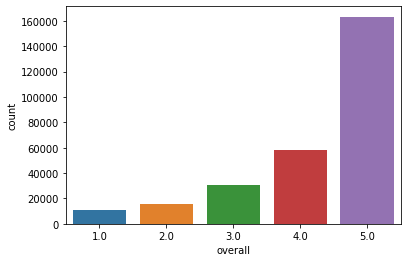

time: 526 ms (started: 2022-01-25 03:21:46 +00:00)


In [ ]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.countplot(df.overall);

In [ ]:
#num of records for ratings 4 or 5 (will bin them into positive)
df[(df["overall"]==5.0) | (df["overall"]==4.0)].shape[0]

221597

time: 96.8 ms (started: 2022-01-25 03:21:49 +00:00)


In [ ]:
#num of records for ratings 3 and below (will bin them into positive)
df[(df["overall"] <= 3)].shape[0]

57080

time: 34.9 ms (started: 2022-01-25 03:21:51 +00:00)


In [ ]:
df[(df["overall"] <= 3)].shape[0] / df.shape[0]

0.2048249407019596

time: 30.3 ms (started: 2022-01-25 03:21:53 +00:00)


20% of overall dataset will be binned into Negative reviews (those with ratings 3 and below)

Remaining 80% will be binned into Positive reviews (those with ratings 4 and above)

This will be done during data preprocessing.

## Check for missing values

In [ ]:
df.isnull().sum()

reviewerID          0
asin                0
reviewerName      452
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

time: 185 ms (started: 2022-01-25 03:21:55 +00:00)


## Check for duplicated product reviews

In [ ]:
# df.duplicated()

time: 935 µs (started: 2022-01-21 04:23:38 +00:00)


In [ ]:
# df.duplicated().sum()

time: 1.42 ms (started: 2022-01-21 04:23:38 +00:00)


## Check for artifacts (symbols, formattings, punctuations, html tags etc)

Inspecting `reviewText` to check for presence of non-text items, which we need to take care during data cleaning

In [ ]:
df.reviewText[0]

"This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++"

time: 4.2 ms (started: 2022-01-25 03:22:04 +00:00)


In [ ]:
df.reviewText[10]

'Wonder my niece wears it every single day, yellow is her favorite color right now an this cute little tutu made he da. It is well built and we hope she gets lots of wear out of it.'

time: 4.25 ms (started: 2022-01-25 03:22:06 +00:00)


In [ ]:
df.reviewText[99]

'great  no one got my good stuff  It was all hanging around my neck.  sturdy and durable, i bought one for my husband'

time: 2.85 ms (started: 2022-01-25 03:22:08 +00:00)


Presence of dollar sign ($), plus sign, full stop, exclaimation marks (generally the usual punctuations) 

In [ ]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"
...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5.0,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5.0,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5.0,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5.0,Holds Up Well In Real World Test,1404691200,"07 7, 2014"


time: 76.3 ms (started: 2022-01-25 03:22:10 +00:00)


## Review Length distribution

Rough sensing of the length of each review corpus. Also check if there are presence of length=0, which we will need to discard them before model training. 

In [ ]:
df["reviewText_len"] = df["reviewText"].astype(str).apply(len)

time: 189 ms (started: 2022-01-25 03:22:14 +00:00)


In [ ]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewText_len
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011",172
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013",306
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013",312
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014",405
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014",453
...,...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5.0,These have literally changed the way I travel!,1403568000,"06 24, 2014",1315
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5.0,Wonderful for Better Packing,1403740800,"06 26, 2014",827
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5.0,"Convenient, lightweight, and durable",1402185600,"06 8, 2014",914
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5.0,Holds Up Well In Real World Test,1404691200,"07 7, 2014",1126


time: 77.2 ms (started: 2022-01-25 03:22:15 +00:00)


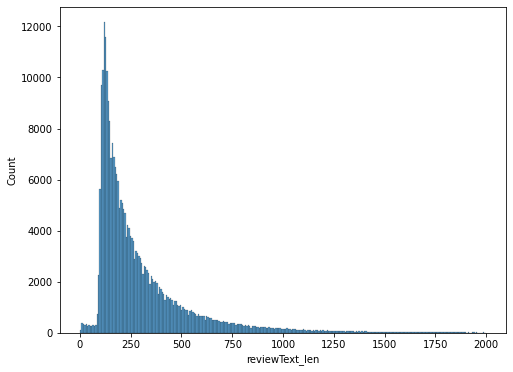

time: 1.02 s (started: 2022-01-25 03:22:19 +00:00)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.histplot(df[df["reviewText_len"] < 2000]["reviewText_len"]);

In [ ]:
df["reviewText_len"].max(), df["reviewText_len"].min()

(22646, 0)

time: 6.16 ms (started: 2022-01-25 03:22:23 +00:00)


# Feature Engineering

## Drop features that are not useful

In [ ]:
df_raw = df.copy()

time: 38 ms (started: 2022-01-25 03:22:26 +00:00)


In [ ]:
def drop_features(df):
  return df.drop(["reviewerID", "reviewerName", "helpful", "unixReviewTime"], axis=1)

time: 1.09 ms (started: 2022-01-25 03:22:28 +00:00)


## Feature engineer reviewTime

Feature engineer datetime variable, as initial raw `reviewTime` is not friendly for data processing. 

In [ ]:
import datetime

def create_review_time(df):
  # Splitting the date 
  temp_dt = df["reviewTime"].str.split(",", n = 1, expand = True) 
    
  # adding date to the main dataset 
  df["date"]= temp_dt[0] 
    
  # adding year to the main dataset 
  df["year"]= temp_dt[1]

  temp_dt = df["date"].str.split(" ", n = 1, expand = True) 
    
  # adding month to the main dataset 
  df["month"]= temp_dt[0] 
    
  # adding day to the main dataset 
  df["day"]= temp_dt[1] 

  df = df.drop(["date", "reviewTime"], axis=1)

  df["reviewTime"] = pd.to_datetime(df[["year", "month", "day"]])
  
  df = df.drop(["year", "month", "day"], axis=1)

  return df

time: 11.4 ms (started: 2022-01-25 03:22:29 +00:00)


In [ ]:
# import datetime

# # df["reviewTime"] = datetime.datetime(df["year"], df["month"], df["day"])
# df["reviewTime"] = pd.to_datetime(df[["year", "month", "day"]])
# df = df.drop(["year", "month", "day"], axis=1)
# df.head()

time: 1.21 ms (started: 2022-01-21 04:23:40 +00:00)


## Concatenating `summary` and `reviewText`

As we do not want to lose info that captures customer satisfactions

In [ ]:
def create_review(df):
  df["review"] = df["reviewText"] + " " + df["summary"]
  df = df.drop(["reviewText", "summary"], axis=1)
  return df

time: 2.1 ms (started: 2022-01-25 03:22:33 +00:00)


In [ ]:
# df[["reviewText", "summary", "review"]].loc[1][0]

time: 909 µs (started: 2022-01-21 04:23:40 +00:00)


In [ ]:
# df[["reviewText", "summary", "review"]].loc[1][1]

time: 867 µs (started: 2022-01-21 04:23:40 +00:00)


In [ ]:
# df[["reviewText", "summary", "review"]].loc[1][2]

time: 999 µs (started: 2022-01-21 04:23:40 +00:00)


In [ ]:
# df = df.drop(["reviewText", "summary"], axis=1)

time: 850 µs (started: 2022-01-21 04:23:40 +00:00)


## Creating bins 

To classify positive, negative reviews

In [ ]:
def create_bins(rating):
  if rating >= 4.0:
    val = "pos"
  else:
    val = "neg"
  return val

time: 2.23 ms (started: 2022-01-25 03:22:36 +00:00)


In [ ]:
def create_sentiment(df):
  df["sentiment"] = df["overall"].apply(create_bins)
  return df

time: 2.59 ms (started: 2022-01-25 03:22:38 +00:00)


## Creating data cleaning pipeline

In [ ]:
df = drop_features(df)

df = create_review_time(df)

df = create_review(df)

df = create_sentiment(df)

time: 5.9 s (started: 2022-01-25 03:22:40 +00:00)


In [ ]:
df.head()

,asin,overall,reviewText_len,reviewTime,review,sentiment
0,0000031887,5.0,172,2011-02-12,This is a great tutu and at a really great pri...,pos
1,0000031887,5.0,306,2013-01-19,I bought this for my 4 yr old daughter for dan...,pos
2,0000031887,5.0,312,2013-01-04,What can I say... my daughters have it in oran...,pos
3,0000031887,5.0,405,2014-04-27,"We bought several tutus at once, and they are ...",pos
4,0000031887,5.0,453,2014-03-15,Thank you Halo Heaven great product for Little...,pos


time: 23.5 ms (started: 2022-01-25 03:22:48 +00:00)


## Exploring new bins created for dependent variable

Inspecting new bins created:

In [ ]:
df[df["overall"]==5][["overall", "sentiment"]].head(3)

,overall,sentiment
0,5.0,pos
1,5.0,pos
2,5.0,pos


time: 63.4 ms (started: 2022-01-25 03:23:01 +00:00)


In [ ]:
df[df["overall"]==1][["overall", "sentiment"]].head(3)

,overall,sentiment
17,1.0,neg
33,1.0,neg
70,1.0,neg


time: 21.4 ms (started: 2022-01-25 03:23:03 +00:00)


In [ ]:
df[df["overall"]==3][["overall", "sentiment"]].head(3)

,overall,sentiment
15,3.0,neg
26,3.0,neg
27,3.0,neg


time: 23.5 ms (started: 2022-01-25 03:23:06 +00:00)


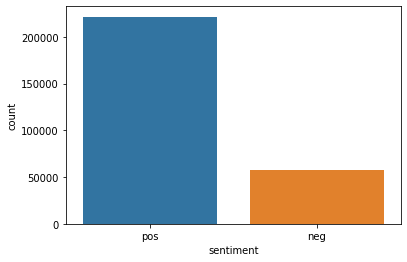

time: 272 ms (started: 2022-01-25 03:23:09 +00:00)


In [ ]:
sns.countplot(df["sentiment"]);

In [ ]:
df[df["sentiment"]=="neg"]["sentiment"].count() / df.shape[0]

0.2048249407019596

time: 36.9 ms (started: 2022-01-25 03:23:30 +00:00)


In [ ]:
df[df["sentiment"]=="pos"]["sentiment"].count() / df.shape[0]

0.7951750592980403

time: 62.3 ms (started: 2022-01-25 03:23:30 +00:00)


After binning, we will have 21% negaetive reviews, and 79% positive reviews.

## Check for review with len=0

Will require to remove those reviews with length=0

In [ ]:
df[df["reviewText_len"]==0].shape

(24, 6)

time: 7.98 ms (started: 2022-01-25 03:23:35 +00:00)


In [ ]:
def drop_review_len_zero(df):
  return df.drop(df[df["reviewText_len"]==0].index)

time: 1.52 ms (started: 2022-01-27 01:42:16 +00:00)


In [ ]:
df = drop_review_len_zero(df)

time: 172 ms (started: 2022-01-25 03:23:39 +00:00)


In [ ]:
#post dropping review len=0
df[df["reviewText_len"]==0].shape

(0, 6)

time: 10.5 ms (started: 2022-01-25 03:23:41 +00:00)


# Data Cleaning
Below are list of things to be cleaned, not limited to, before modelling begins

*   remove punctuations
*   lower case



In [ ]:
df.head(3)

,asin,overall,reviewText_len,reviewTime,review,sentiment
0,0000031887,5.0,172,2011-02-12,This is a great tutu and at a really great pri...,pos
1,0000031887,5.0,306,2013-01-19,I bought this for my 4 yr old daughter for dan...,pos
2,0000031887,5.0,312,2013-01-04,What can I say... my daughters have it in oran...,pos


time: 19.7 ms (started: 2022-01-25 03:24:17 +00:00)


In [ ]:
df["review"][0]

"This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++ Great tutu-  not cheaply made"

time: 14.4 ms (started: 2022-01-25 03:24:19 +00:00)


In [ ]:
df["review"][99]

'great  no one got my good stuff  It was all hanging around my neck.  sturdy and durable, i bought one for my husband great'

time: 2.39 ms (started: 2022-01-25 03:24:21 +00:00)


## Remove punctuations and lower case

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

time: 3.39 ms (started: 2022-01-27 01:42:09 +00:00)


In [ ]:
def remove_punctuation(review):
  no_punct = [words.lower() for words in review if words not in string.punctuation]
  review_wo_punct= "".join(no_punct)
  return review_wo_punct

time: 3.04 ms (started: 2022-01-27 01:42:10 +00:00)


In [ ]:
df["review_no_punct"] = df["review"].apply(remove_punctuation)

time: 18.3 s (started: 2022-01-25 03:24:38 +00:00)


In [ ]:
df[["review", "review_no_punct"]].loc[0][0]

"This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++ Great tutu-  not cheaply made"

time: 77 ms (started: 2022-01-25 03:24:59 +00:00)


In [ ]:
df[["review", "review_no_punct"]].loc[0][1]

'this is a great tutu and at a really great price it doesnt look cheap at all im so glad i looked on amazon and found such an affordable tutu that isnt made poorly a great tutu  not cheaply made'

time: 30.7 ms (started: 2022-01-25 03:25:01 +00:00)


## Lemmatize review corpus

In [ ]:
df.head(3)

,asin,overall,reviewText_len,reviewTime,review,sentiment,review_no_punct
0,0000031887,5.0,172,2011-02-12,This is a great tutu and at a really great pri...,pos,this is a great tutu and at a really great pri...
1,0000031887,5.0,306,2013-01-19,I bought this for my 4 yr old daughter for dan...,pos,i bought this for my 4 yr old daughter for dan...
2,0000031887,5.0,312,2013-01-04,What can I say... my daughters have it in oran...,pos,what can i say my daughters have it in orange ...


time: 20.5 ms (started: 2022-01-25 03:25:11 +00:00)


In [ ]:
# pip install nltk

time: 716 µs (started: 2022-01-25 03:25:18 +00:00)


In [ ]:
# pip install stopwords

time: 3.28 s (started: 2022-01-21 04:35:00 +00:00)


In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def lemmatize_review(review):
    lemmatizer = nltk.WordNetLemmatizer()
    tokenized_lines = nltk.word_tokenize(review)
    for i in range(len(tokenized_lines)):
        lammatize_words = [
            lemmatizer.lemmatize(word).lower()
            for word in tokenized_lines
            if not word.lower() in set(stopwords.words("english"))
        ]
        return " ".join(lammatize_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
time: 1.96 s (started: 2022-01-27 01:43:08 +00:00)


In [ ]:
# df["lemmatized_review"] = df["review_no_punct"].apply(lemmatize_review)

time: 40min 22s (started: 2022-01-21 04:36:39 +00:00)


In [ ]:
#read from csv to avoid long running lemmatizing process
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Amazon_Product_Review/data.csv")

time: 3.51 s (started: 2022-01-27 01:41:37 +00:00)


Note: Lemmatizing entire doc took 40min 22sec

Inspecting lemmatizing...

In [ ]:
df[["review_no_punct", "lemmatized_review"]].loc[0][0]

'this is a great tutu and at a really great price it doesnt look cheap at all im so glad i looked on amazon and found such an affordable tutu that isnt made poorly a great tutu  not cheaply made'

time: 32.7 ms (started: 2022-01-27 01:41:43 +00:00)


In [ ]:
df[["review_no_punct", "lemmatized_review"]].loc[0][1]

'great tutu really great price doesnt look cheap im glad looked amazon found affordable tutu isnt made poorly great tutu cheaply made'

time: 56.5 ms (started: 2022-01-27 01:41:44 +00:00)


In [ ]:
df[["review_no_punct", "lemmatized_review"]].loc[99][0]

'great  no one got my good stuff  it was all hanging around my neck  sturdy and durable i bought one for my husband great'

time: 108 ms (started: 2022-01-27 01:41:46 +00:00)


In [ ]:
df[["review_no_punct", "lemmatized_review"]].loc[99][1]

'great one got good stuff hanging around neck sturdy durable bought one husband great'

time: 63.9 ms (started: 2022-01-27 01:41:47 +00:00)


In [ ]:
# df.to_csv("data.csv", index=False)

time: 913 µs (started: 2022-01-27 01:41:48 +00:00)


## Create tokenizer

In [ ]:
def tokenize_lines(text):
    return nltk.word_tokenize(text)

time: 1.71 ms (started: 2022-01-27 01:41:54 +00:00)


In [ ]:
def tokenize(review):
    review = remove_punctuation(review)
    review = lemmatize_review(review)
    review = tokenize_lines(review)
    return review

time: 2.14 ms (started: 2022-01-27 01:41:56 +00:00)


In [ ]:
sample_review1 = tokenize(df["review"][99])
sample_review1

['great',
 'one',
 'got',
 'good',
 'stuff',
 'hanging',
 'around',
 'neck',
 'sturdy',
 'durable',
 'bought',
 'one',
 'husband',
 'great']

time: 1.77 s (started: 2022-01-27 01:43:13 +00:00)


# Modelling

In [ ]:
df.head(3)

,asin,overall,reviewText_len,reviewTime,review,sentiment,review_no_punct,lemmatized_review
0,0000031887,5.0,172,2011-02-12,This is a great tutu and at a really great pri...,pos,this is a great tutu and at a really great pri...,great tutu really great price doesnt look chea...
1,0000031887,5.0,306,2013-01-19,I bought this for my 4 yr old daughter for dan...,pos,i bought this for my 4 yr old daughter for dan...,bought 4 yr old daughter dance class wore toda...
2,0000031887,5.0,312,2013-01-04,What can I say... my daughters have it in oran...,pos,what can i say my daughters have it in orange ...,say daughter orange black white pink thinking ...


time: 28 ms (started: 2022-01-27 01:43:21 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def get_X_y(df):
    y = df.sentiment
    X = df.lemmatized_review
    y = np.array(list(map(lambda x: 1 if x == "pos" else 0, y)))
    return X, y

time: 8.47 ms (started: 2022-01-27 01:43:25 +00:00)


In [ ]:
X, y = get_X_y(df)

time: 82.1 ms (started: 2022-01-27 01:43:29 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

time: 161 ms (started: 2022-01-27 01:43:31 +00:00)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english')

time: 1.26 ms (started: 2022-01-27 01:43:36 +00:00)


In [ ]:
train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)

test_tfidf_matrix = tfidf_vectorizer.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  % sorted(inconsistent)


time: 23min 33s (started: 2022-01-27 01:43:38 +00:00)


In [ ]:
train_tfidf_matrix.shape

(222922, 152505)

time: 9 ms (started: 2022-01-27 02:07:15 +00:00)


## RandomForest

In [ ]:
 # RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

rf_clf = RandomForestClassifier(n_estimators=500)

rf_clf.fit(train_tfidf_matrix, y_train)

# y_pred = rf_clf.predict(test_tfidf_matrix)

time: 2h 20min 42s (started: 2022-01-21 06:18:36 +00:00)


In [ ]:
y_pred = rf_clf.predict(test_tfidf_matrix)

time: 36.5 s (started: 2022-01-21 08:57:03 +00:00)


Text(0.5, 1.0, 'Confusion Matrix')

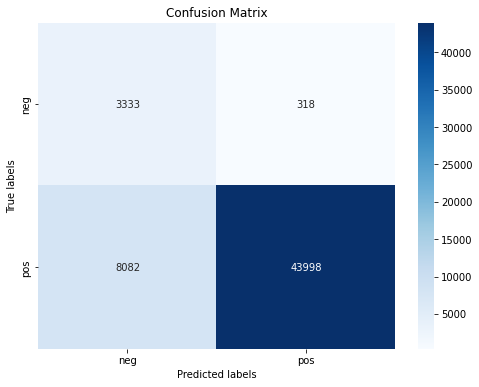

time: 228 ms (started: 2022-01-21 08:57:52 +00:00)


In [ ]:
label_names = ["neg", "pos"]

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.29      0.44     11415
           1       0.84      0.99      0.91     44316

    accuracy                           0.85     55731
   macro avg       0.88      0.64      0.68     55731
weighted avg       0.86      0.85      0.82     55731

time: 108 ms (started: 2022-01-21 08:57:55 +00:00)


## Log Reg

In [ ]:
# Logistic Reg
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

log_reg.fit(train_tfidf_matrix, y_train)

y_pred = log_reg.predict(test_tfidf_matrix)

time: 13 s (started: 2022-01-21 08:58:14 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Text(0.5, 1.0, 'Confusion Matrix')

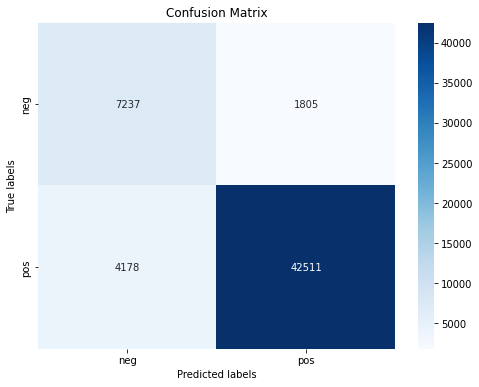

time: 223 ms (started: 2022-01-21 08:58:29 +00:00)


In [ ]:
label_names = ["neg", "pos"]

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.63      0.71     11415
           1       0.91      0.96      0.93     44316

    accuracy                           0.89     55731
   macro avg       0.86      0.80      0.82     55731
weighted avg       0.89      0.89      0.89     55731

time: 112 ms (started: 2022-01-21 08:58:32 +00:00)


## SVM

In [ ]:
from sklearn.svm import SVC

# SVC
svc = SVC()

svc.fit(train_tfidf_matrix, y_train)

SVC()

time: 4h 25min 13s (started: 2022-01-27 02:07:32 +00:00)


In [ ]:
y_pred = svc.predict(test_tfidf_matrix)

time: 27min 58s (started: 2022-01-27 07:20:54 +00:00)


Text(0.5, 1.0, 'Confusion Matrix')

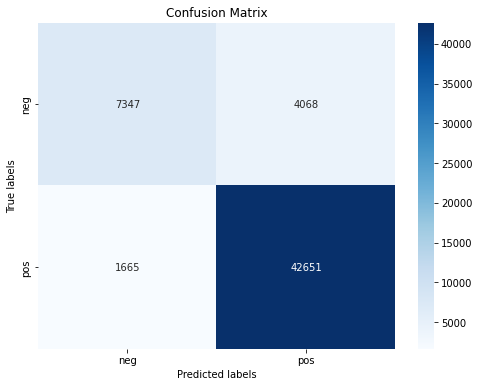

time: 846 ms (started: 2022-01-27 07:57:40 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

label_names = ["neg", "pos"]

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.64      0.72     11415
           1       0.91      0.96      0.94     44316

    accuracy                           0.90     55731
   macro avg       0.86      0.80      0.83     55731
weighted avg       0.89      0.90      0.89     55731

time: 450 ms (started: 2022-01-27 07:58:06 +00:00)


## After using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

time: 844 µs (started: 2022-01-21 08:58:44 +00:00)


In [ ]:
from collections import Counter

print(f'Original dataset shape : {Counter(y_train)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(train_tfidf_matrix, y_train)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({1: 177262, 0: 45660})
Resampled dataset shape Counter({1: 177262, 0: 177262})
time: 1min 16s (started: 2022-01-21 08:58:46 +00:00)


In [ ]:
# Logistic Reg
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

log_reg.fit(X_res, y_res)

y_pred = log_reg.predict(test_tfidf_matrix)

time: 18 s (started: 2022-01-21 09:01:38 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Text(0.5, 1.0, 'Confusion Matrix')

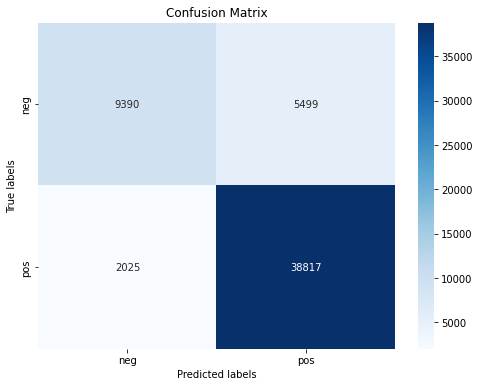

time: 217 ms (started: 2022-01-21 09:02:02 +00:00)


In [ ]:
label_names = ["neg", "pos"]

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.82      0.71     11415
           1       0.95      0.88      0.91     44316

    accuracy                           0.86     55731
   macro avg       0.79      0.85      0.81     55731
weighted avg       0.88      0.86      0.87     55731

time: 116 ms (started: 2022-01-21 09:02:05 +00:00)


# DistilBert

## Data Prep

In [ ]:
#read from csv to avoid long running lemmatizing process
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Amazon_Product_Review/data.csv")

time: 5.06 s (started: 2022-01-27 01:39:53 +00:00)


In [ ]:
import numpy as np

def get_X_y(df):
    y = df.sentiment
    X = df.lemmatized_review
    y = np.array(list(map(lambda x: 1 if x == "pos" else 0, y)))
    return X, y

X, y = get_X_y(df)

time: 287 ms (started: 2022-01-27 01:40:11 +00:00)


In [ ]:
X[:5]

0    great tutu really great price doesnt look chea...
1    bought 4 yr old daughter dance class wore toda...
2    say daughter orange black white pink thinking ...
3    bought several tutu got high review sturdy see...
4    thank halo heaven great product little girl gr...
Name: lemmatized_review, dtype: object

time: 7.01 ms (started: 2022-01-27 01:40:14 +00:00)


In [ ]:
y[:5]

array([1, 1, 1, 1, 1])

time: 9.19 ms (started: 2022-01-27 01:40:16 +00:00)


In [ ]:
import numpy as np
sample_data_size= 1000
idx = np.random.choice(np.arange(len(X)), sample_data_size, replace=False)

time: 15.7 ms (started: 2022-01-27 01:40:19 +00:00)


In [ ]:
X_small = np.array(X)[idx]
y_small = np.array(y)[idx]
len(X_small), len(y_small)

(1000, 1000)

time: 17.1 ms (started: 2022-01-27 01:40:20 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.20, random_state=42)

time: 467 ms (started: 2022-01-27 01:40:22 +00:00)


In [ ]:
#check for test set label distributions
count1 = (y_test == 1).sum()
count0 = (y_test == 0).sum()
count1, count0

(168, 32)

time: 11 ms (started: 2022-01-27 01:40:24 +00:00)


In [ ]:
len(X_test), len(y_test), len(X_train), len(y_train)

(200, 200, 800, 800)

time: 5.19 ms (started: 2022-01-27 01:40:26 +00:00)


## Importing transformers

In [ ]:
pip install transformers

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertTokenizerFast
d_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
test_document = "The Gunners, to all extents and purposes, are planning to clash with the Whites \
later on this evening - with all the rest of Saturday's Premier League fixtures being postponed due to a \
high number of positive Covid-19 cases."

time: 5.59 ms (started: 2022-01-25 03:51:17 +00:00)


In [ ]:
#trial document
#without padding, masking yet
test_inputs = d_tokenizer(test_document, return_tensors="tf")
test_inputs

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[  101,  1996, 29000,  1010,  2000,  2035,  6698,  2015,  1998,
         5682,  1010,  2024,  4041,  2000, 13249,  2007,  1996, 12461,
         2101,  2006,  2023,  3944,  1011,  2007,  2035,  1996,  2717,
         1997,  5095,  1005,  1055,  4239,  2223, 17407,  2108, 14475,
         2349,  2000,  1037,  2152,  2193,  1997,  3893,  2522, 17258,
         1011,  2539,  3572,  1012,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]], dtype=int32)>}

time: 118 ms (started: 2022-01-25 03:51:19 +00:00)


## Experiment 1 - Max Length = 128

In [ ]:
#take in X_data, perform encoding necessary for transformers to process
#convert words to input ids
#with attention masking, since paddings are done

import tensorflow as tf

max_length= 128
def batch_encode(d_tokenizer, texts, batch_size=32, max_length=max_length):
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = d_tokenizer.batch_encode_plus(batch,
                                             max_length=max_length, #max length per document to be encoded
                                             padding="max_length", #pad all to max length, if not long enough
                                             truncation=True, #if beyond max length, will force-truncate to max length
                                             return_attention_mask=True,
                                             return_token_type_ids=False #not required for TF fitting
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)
#     return input_ids, attention_mask

time: 12.8 ms (started: 2022-01-25 03:55:16 +00:00)


In [ ]:
len(X_train)

800

time: 10.9 ms (started: 2022-01-25 03:55:18 +00:00)


In [ ]:
X_train_ids, X_train_attention = batch_encode(d_tokenizer, X_train.tolist())

X_test_ids, X_test_attention = batch_encode(d_tokenizer, X_test.tolist())

time: 484 ms (started: 2022-01-25 03:55:19 +00:00)


In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

#The dropout probability for all fully connected layers in the embeddings, encoder, and pooler.
#this is one possible field to tune
d_dropout_rate = 0.25

#The dropout ratio for the attention probabilities.
#this is one possible field to tune
d_attention_dropout_rate = 0.25
 
#DistilBERT's initialization
config = DistilBertConfig(dropout=d_dropout_rate, 
                          attention_dropout=d_attention_dropout_rate)
                          
# distilBERT_transformer = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
distilBERT_transformer = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Make DistilBERT layers untrainable
# for layer in distilBERT_transformer.layers:
#     layer.trainable = False

# Make DistilBERT layers trainable
for layer in distilBERT_transformer.layers:
    layer.trainable = True

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


time: 13.3 s (started: 2022-01-25 03:58:11 +00:00)


In [ ]:
max_length = 128
learning_rate = 1e-4

# Define input layers
input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                        name='input_ids', 
                                        dtype='int32')

input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                              name='input_attention', 
                                              dtype='int32')

#distilBERT_transformer outputs last year at the first element index[0]
#we want the "last" hidden state from distilBERT, hence [0]
last_hidden_state = distilBERT_transformer([input_ids_layer, input_attention_layer])[0]

cls_token = last_hidden_state[:, 0, :]

output = tf.keras.layers.Dense(1,activation='sigmoid')(cls_token)

time: 9.25 s (started: 2022-01-25 03:58:35 +00:00)


In [ ]:
distilbert_model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

time: 13.5 ms (started: 2022-01-25 03:59:00 +00:00)


In [ ]:
distilbert_model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss= "binary_crossentropy",
                  metrics=['accuracy'])

time: 40.3 ms (started: 2022-01-25 03:59:06 +00:00)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="min",
                                                  patience=1,
                                                  restore_best_weights=True)

time: 1.86 ms (started: 2022-01-25 03:59:12 +00:00)


In [ ]:
history1 = distilbert_model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    epochs=2
)

Epoch 1/2
20/20 [==============================] - 455s 23s/step - loss: 0.1576 - accuracy: 0.9422 - val_loss: 0.4203 - val_accuracy: 0.8562
Epoch 2/2
20/20 [==============================] - 437s 22s/step - loss: 0.1734 - accuracy: 0.9469 - val_loss: 0.7217 - val_accuracy: 0.7688
time: 14min 52s (started: 2022-01-25 06:13:09 +00:00)


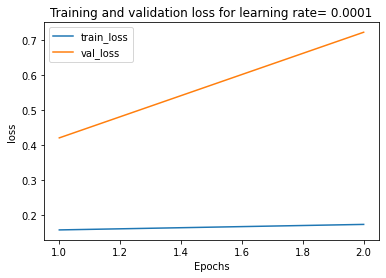

time: 165 ms (started: 2022-01-25 06:30:45 +00:00)


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, metric, lr):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric + " for learning rate= " + str(lr))
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_loss_accuracy(history1, "loss", learning_rate)

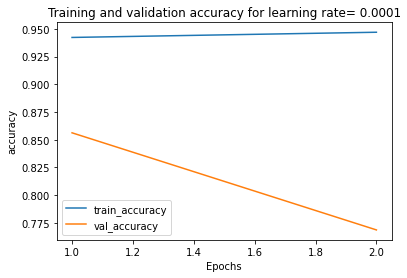

time: 157 ms (started: 2022-01-25 06:30:50 +00:00)


In [ ]:
plot_loss_accuracy(history1, "accuracy", learning_rate)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = distilbert_model.predict([X_test_ids, X_test_attention])
y_pred = np.where(y_pred >= 0.5, 1, 0)

cm = confusion_matrix(y_test, y_pred)

time: 42.1 s (started: 2022-01-25 06:30:55 +00:00)


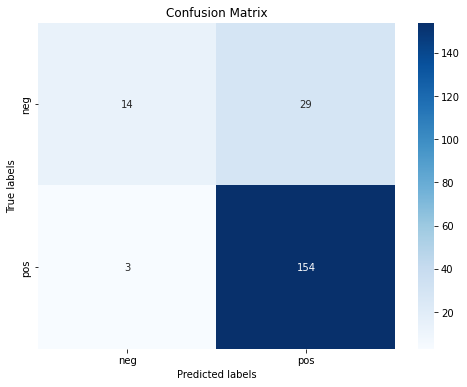

time: 273 ms (started: 2022-01-25 06:31:41 +00:00)


In [ ]:
import seaborn as sns
plt.figure(figsize = (8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')

label_names = ["neg", "pos"]

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names);
ax.yaxis.set_ticklabels(label_names);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.33      0.47        43
           1       0.84      0.98      0.91       157

    accuracy                           0.84       200
   macro avg       0.83      0.65      0.69       200
weighted avg       0.84      0.84      0.81       200

time: 7.24 ms (started: 2022-01-25 06:31:46 +00:00)


## Experiment 2 - Max Length = 256

In [ ]:
max_length= 256
def batch_encode(d_tokenizer, texts, batch_size=32, max_length=max_length):
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = d_tokenizer.batch_encode_plus(batch,
                                             max_length=max_length, #max length per document to be encoded
                                             padding="max_length", #pad all to max length, if not long enough
                                             truncation=True, #if beyond max length, will force-truncate to max length
                                             return_attention_mask=True,
                                             return_token_type_ids=False #not required for TF fitting
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)
#     return input_ids, attention_mask

time: 35.2 ms (started: 2022-01-25 06:33:07 +00:00)


In [ ]:
X_train_ids, X_train_attention = batch_encode(d_tokenizer, X_train.tolist())

X_test_ids, X_test_attention = batch_encode(d_tokenizer, X_test.tolist())

time: 452 ms (started: 2022-01-25 06:33:17 +00:00)


In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

d_dropout_rate = 0.25

d_attention_dropout_rate = 0.25
 
#DistilBERT's initialization
config = DistilBertConfig(dropout=d_dropout_rate, 
                          attention_dropout=d_attention_dropout_rate)
                          
# distilBERT_transformer = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
distilBERT_transformer = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Make DistilBERT layers untrainable
# for layer in distilBERT_transformer.layers:
#     layer.trainable = False

# Make DistilBERT layers trainable
for layer in distilBERT_transformer.layers:
    layer.trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


time: 4.8 s (started: 2022-01-25 06:33:28 +00:00)


In [ ]:
max_length = 256
learning_rate = 1e-5

# Define input layers
input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                        name='input_ids', 
                                        dtype='int32')

input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                              name='input_attention', 
                                              dtype='int32')

last_hidden_state = distilBERT_transformer([input_ids_layer, input_attention_layer])[0]

cls_token = last_hidden_state[:, 0, :]

output = tf.keras.layers.Dense(1,activation='sigmoid')(cls_token)

time: 960 ms (started: 2022-01-25 07:14:44 +00:00)


In [ ]:
distilbert_model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

time: 7.26 ms (started: 2022-01-25 07:14:46 +00:00)


In [ ]:
distilbert_model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss= "binary_crossentropy",
                  metrics=['accuracy'])

time: 13.6 ms (started: 2022-01-25 07:14:48 +00:00)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="min",
                                                  patience=1,
                                                  restore_best_weights=True)

time: 2.1 ms (started: 2022-01-25 07:14:52 +00:00)


In [ ]:
history2 = distilbert_model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    epochs=5
)

Epoch 1/5
20/20 [==============================] - 977s 48s/step - loss: 0.4650 - accuracy: 0.7500 - val_loss: 0.3666 - val_accuracy: 0.8375
Epoch 2/5
20/20 [==============================] - 994s 50s/step - loss: 0.3194 - accuracy: 0.8484 - val_loss: 0.3606 - val_accuracy: 0.8438
Epoch 3/5
20/20 [==============================] - 1000s 50s/step - loss: 0.2616 - accuracy: 0.8875 - val_loss: 0.3551 - val_accuracy: 0.8375
Epoch 4/5
20/20 [==============================] - 1014s 51s/step - loss: 0.1996 - accuracy: 0.9359 - val_loss: 0.3665 - val_accuracy: 0.8500
time: 1h 6min 24s (started: 2022-01-25 07:14:57 +00:00)


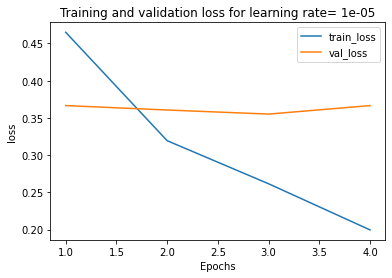

time: 229 ms (started: 2022-01-25 08:21:30 +00:00)


In [ ]:
plot_loss_accuracy(history2, "loss", learning_rate)

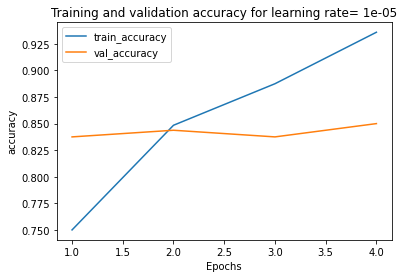

time: 194 ms (started: 2022-01-25 08:21:33 +00:00)


In [ ]:
plot_loss_accuracy(history2, "accuracy", learning_rate)

In [ ]:
y_pred = distilbert_model.predict([X_test_ids, X_test_attention])
y_pred = np.where(y_pred >= 0.5, 1, 0)

cm = confusion_matrix(y_test, y_pred)

time: 1min 31s (started: 2022-01-25 08:21:36 +00:00)


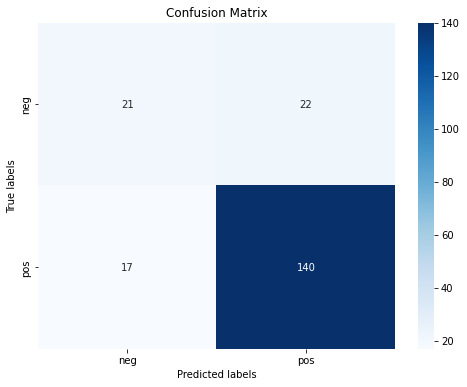

time: 277 ms (started: 2022-01-25 08:23:12 +00:00)


In [ ]:
import seaborn as sns
plt.figure(figsize = (8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')

label_names = ["neg", "pos"]

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names);
ax.yaxis.set_ticklabels(label_names);

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.49      0.52        43
           1       0.86      0.89      0.88       157

    accuracy                           0.81       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.80      0.81      0.80       200

time: 13.1 ms (started: 2022-01-25 08:23:17 +00:00)
